#### Import libraries & set-up holidays

In [7]:
import pandas as pd
import numpy as np
#import tiingo
import requests
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

## Create holiday calendar
cal = calendar()

holidays = cal.holidays(start='2000-01-01',
                        end='2030-12-30')

holiday_df = pd.DataFrame(data=holidays,
                          columns = ['date']).assign(holiday='USFederalHoliday')

holiday_df.rename(columns={'date':'ds'},inplace=True)
#holiday_df.to_csv('us_holidays_until_2030.csv')

In [8]:
### First we will get the 15min time intervals and calculate the 15min Moving averages (10 perido, 20 period, 50 period)
### From the same data we will also calculate the 1d Moving averages (10 period, 20 period, 50 period) and
### Append the indicators to the dataframe 
### Each iteration will run for a single ticker


### The data extracts work in 0GMT => Exchange opens at 14:30 and closes at 21:00
### Convert this to Sofia/New-York time if needed


#### Connect to tiingo

In [9]:
ticker = 'SPY'
start_date = '2020-01-01'
### The data extracts work in 0GMT => Exchange opens at 14:30 and closes at 21:00
### Convert this to Sofia/New-York time if needed

#### Connect to tiingo
# 15min to # 1h 
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/tiingo/daily/"+str(ticker)+"/prices?startDate="+str(start_date)+"&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json())


In [10]:
df_stock = pd.DataFrame(requestResponse.json()) 
#df_stock
## This gets financial data
#requestResponse = requests.get("https://api.tiingo.com/tiingo/fundamentals/msft/statements?token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json)
requestResponse
df_stock = pd.DataFrame(requestResponse.json()) 
#df_stock
df_stock.date = pd.to_datetime(df_stock.date)
#df_stock.date.dt.date
## Remove the US public holidays
df_stock = df_stock[~df_stock.date.dt.date.isin(holiday_df.ds)]
#df_stock.dtypes
df_stock.rename(columns={"date": "ds", "close": "y"},inplace=True)
df_stock.ds = df_stock.ds.dt.tz_convert(None)
df_stock.ds.dt.day_name().value_counts()

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\algorithms.py:524: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


Tuesday      153
Wednesday    152
Thursday     150
Friday       146
Monday       138
Name: ds, dtype: int64

#### Prophet

In [11]:
# Python
m = Prophet(holidays=holiday_df, growth = 'linear')
# m = Prophet(holidays=holiday_df, growth = 'linear')
m.fit(df_stock[['ds','y']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [12]:
df_cv = cross_validation(m, horizon='30 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)

INFO:prophet:Making 45 forecasts with cutoffs between 2021-01-15 00:00:00 and 2022-11-06 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209D3278130>


In [13]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,708.06457,26.609483,19.672433,0.04724,0.033618,0.047748,0.362272


In [14]:
# Python
# Frequency 5min for minute ones D for daily
future = m.make_future_dataframe(periods=100, freq='D')
future.tail()

,ds
834,2023-03-12
835,2023-03-13
836,2023-03-14
837,2023-03-15
838,2023-03-16


#### Prediction results

In [15]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100)

,ds,yhat,yhat_lower,yhat_upper
739,2022-12-07,386.591264,373.139187,400.372037
740,2022-12-08,385.469778,373.248802,399.049782
741,2022-12-09,384.565722,371.871623,397.954910
742,2022-12-10,383.469355,370.337062,395.941046
743,2022-12-11,382.760853,370.486478,395.654493
...,...,...,...,...
834,2023-03-12,325.382154,305.632437,345.632186
835,2023-03-13,324.822137,305.776975,344.644709
836,2023-03-14,324.354870,305.193619,344.927337
837,2023-03-15,323.923551,303.292284,343.825288


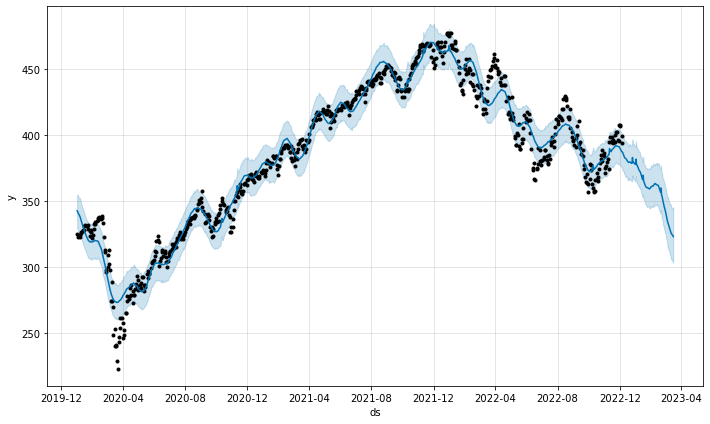

In [16]:
# Python
fig1 = m.plot(forecast)

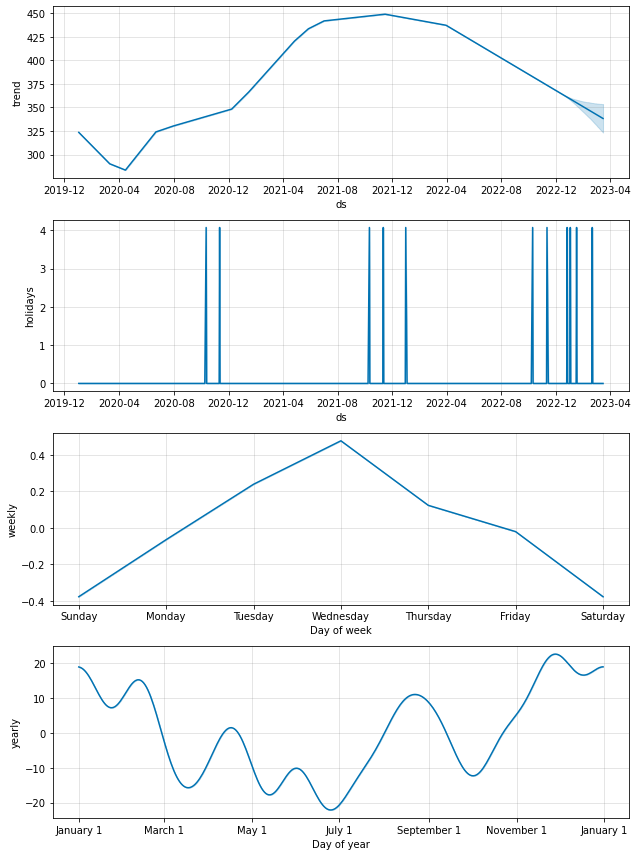

In [17]:
# Python
fig2 = m.plot_components(forecast)

In [18]:
# Python
plot_plotly(m, forecast)

In [19]:
# Python
plot_components_plotly(m, forecast)

#### Hyperparameter tuning

In [20]:
cutoffs = pd.to_datetime(['2020-03-15', '2020-03-16', '2020-03-17'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_stock[['ds','y']])  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209D81AFCA0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209D828BCD0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209D8B323A0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01    17.684465
1                     0.001                     0.10   151.800314
2                     0.001                     1.00   565.714057
3                     0.001                    10.00  3926.316674
4                     0.010                     0.01    17.946011
5                     0.010                     0.10   156.815303
6                     0.010                     1.00   556.027693
7                     0.010                    10.00  3980.080444
8                     0.100                     0.01    50.262813
9                     0.100                     0.10   156.719110
10                    0.100                     1.00   565.662916
11                    0.100                    10.00  3969.177703
12                    0.500                     0.01    70.429167
13                    0.500                     0.10   163.736260
14        

In [21]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


#### Appendix

In [22]:
# import xgboost as xgb 
# clf_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                             tree_method = 'gpu_hist',
#                             gamma = 0.5,
#                            max_depth = 25,
#                             seed=42,
#                             n_estimators=30)

In [23]:
# clf_xgb.fit(X_train,
#             y_train,
#            verbose=True,
#             early_stopping_rounds=20,
#             eval_metric='rmse',   #aucpr,auc, map
#             eval_set=[(X_test,y_test)])

In [24]:
# # import necessary libraries
# import pandas as pd

# # create function to lag close variable
# def lag_close(df, n):
#     df_lag = df[['close']].shift(n)
#     df_lag.columns = ['close_lag'+str(n)]
#     return df_lag

# # apply lag_close function to df with n = 1, 2, 3, 4
# df_1 = pd.concat([df, lag_close(df, 1), lag_close(df, 2), lag_close(df, 3), lag_close(df, 4)], axis=1)


In [31]:
# extract the year, month, day, and hour from the ds column
df_stock['year'] = df_stock['ds'].dt.year
df_stock['month'] = df_stock['ds'].dt.month
df_stock['day'] = df_stock['ds'].dt.day
df_stock['hour'] = df_stock['ds'].dt.hour

# concatenate the new columns with the y column
X = pd.concat([df_stock['year'], df_stock['month'], df_stock['day'], df_stock['hour'], df_stock['y']], axis=1)
y = df_stock['y']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reshape the input data to have the correct shape for the LSTM model
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# define the LSTM model
# define the LSTM model with the correct input shape
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# evaluate the model


Epoch 1/100
15/15 [==============================] - 4s 77ms/step - loss: 151759.2812 - val_loss: 152973.2344
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 151003.8594 - val_loss: 152317.7656
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 150347.1875 - val_loss: 151599.3281
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 149444.7812 - val_loss: 150517.2812
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: 148359.4688 - val_loss: 149466.6875
Epoch 6/100
15/15 [==============================] - 0s 12ms/step - loss: 147492.3125 - val_loss: 148651.5312
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: 146562.2188 - val_loss: 147780.9219
Epoch 8/100
15/15 [==============================] - 0s 7ms/step - loss: 145676.7969 - val_loss: 146565.7188
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: 144555.8750 - val_loss: 145804.2500
Epoch 10/100
15/

In [34]:
mse, mae = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 86385.3438


TypeError: cannot unpack non-iterable float object

In [39]:
mse = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 86385.3438


In [40]:
mse

86385.34375

In [47]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [63]:
from sklearn.model_selection import RandomizedSearchCV

# Define the range of values for each hyperparameter
param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 1, 10, 100],
    "seasonality_prior_scale": [0.001, 0.01, 0.1, 1, 10, 100],
    "holidays_prior_scale": [0.001, 0.01, 0.1, 1, 10, 100],
    "changepoint_range": [0.5, 0.7, 0.9],
}


# Split the data into train and test sets
train_df = df_stock.iloc[:int(len(df) * 0.8)]
test_df = df_stock.iloc[int(len(df) * 0.8):]

# Fit the model on the training data
model = Prophet()
model.fit(train_df)

# Use the model to make predictions on the test set
predictions = model.predict(test_df)

# Calculate the mean absolute error between the predicted and actual values
mae = np.mean(np.abs(predictions.yhat - test_df.y))

# Print the mean absolute error
print(mae)
# Create the model
model = Prophet()

# Use RandomizedSearchCV to sample from the hyperparameter space and find the best combination of values
search = RandomizedSearchCV(
    model, param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=1
)

# Fit the model on the data
search.fit(df_stock)

# Print the best set of hyperparameters
print(search.best_params_)

NameError: name 'df' is not defined

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error



class ProphetWrapper(Prophet):
    def get_params(self, deep=True):
        return {}
    def set_params(self, deep=True):
        return {}


# Define the range of values for each hyperparameter
param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 1, 10, 100]
   # "seasonality_prior_scale": [0.001, 0.01, 0.1, 1, 10, 100],
   # "holidays_prior_scale": [0.001, 0.01, 0.1, 1, 10, 100],
   # "changepoint_range": [0.5, 0.7, 0.9],
}

# Create the model
model = ProphetWrapper()

# Use make_scorer to create a scoring function that uses the mean absolute error
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Use RandomizedSearchCV to sample from the hyperparameter space and find the best combination of values
# using the MAE as the scoring function
search = RandomizedSearchCV(
    model, param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=1, scoring=mae_scorer
)

# Fit the model on the data
search.fit(df_stock)

# Print the best set of hyperparameters
print(search.best_params_)

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning:

The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Fitting 3 folds for each of 6 candidates, totalling 18 fits


TypeError: set_params() got an unexpected keyword argument 'changepoint_prior_scale'

In [82]:
#keras only takes numpy array
training_set = df_stock.iloc[:, 1: 2].values

#### Train LSTM model on the data

In [102]:

from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(df_stock[['y']])

In [103]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [104]:
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

In [105]:
regressor = Sequential()

In [106]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

In [107]:
##add 2nd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

In [108]:
regressor.add(Dense(units = 1))

In [110]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [111]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
22/22 [==============================] - 11s 86ms/step - loss: 0.0677
Epoch 2/100
22/22 [==============================] - 2s 95ms/step - loss: 0.0149
Epoch 3/100
22/22 [==============================] - 2s 83ms/step - loss: 0.0090
Epoch 4/100
22/22 [==============================] - 2s 86ms/step - loss: 0.0094
Epoch 5/100
22/22 [==============================] - 2s 76ms/step - loss: 0.0083
Epoch 6/100
22/22 [==============================] - 2s 79ms/step - loss: 0.0072
Epoch 7/100
22/22 [==============================] - 2s 83ms/step - loss: 0.0086
Epoch 8/100
22/22 [==============================] - 2s 79ms/step - loss: 0.0106
Epoch 9/100
22/22 [==============================] - 2s 77ms/step - loss: 0.0096
Epoch 10/100
22/22 [==============================] - 2s 85ms/step - loss: 0.0070
Epoch 11/100
22/22 [==============================] - 2s 82ms/step - loss: 0.0073
Epoch 12/100
22/22 [==============================] - 2s 84ms/step - loss: 0.0065
Epoch 13/100
22/22 [====